Name of Dataset: TEP (Tennessee Eastman Process)

d00.dat: training file for the normal operating conditions ;  d00_te.dat: testing file for the normal operating conditions  
d01.dat: training file for Fault 1  ;  d01_te.dat: testing file for Fault 1  
.  
.  
.  
d21.dat: training file for Fault 21  ;  d21_te.dat: testing file for Fault 21  

Each training data file contains 480 rows and 52 columns  
Each testing data file contains 960 rows and 52 columns  
An observation vector at a particular time instant is given by x=[XMEAS(1), XMEAS(2), ..., XMEAS(41), XMV(1), ..., XMV(11)]^T where XMEAS(n) is the n-th measured variable and XMV(n) is the n-th manipulated variable.

Use Cases: Classification(Determine class of Fault); Regression(Forecasting of certain variable values from past data)

A. Loading the Dataset and Extracting a single data point

In [1]:
import numpy as np
import matplotlib.pyplot as plt

file_name = 'd01_te.dat'
data = np.loadtxt(file_name)
col_names = [f"XMEAS[{i+1}])" for i in range (42)] + [f"XMV[{i+1}])" for i in range (42, 52)]
print(f"\nShape of the data for {file_name}:", data.shape)
rand_idx = np.random.randint(len(data))
sample = data[rand_idx]
print(f"\nSingle Datapoint Sample (Transposed) at {rand_idx}:\n")
for name, value in zip(col_names, sample):
    print(f"{name}: {value}")


Shape of the data for d01_te.dat: (960, 52)

Single Datapoint Sample (Transposed) at 768:

XMEAS[1]): 0.77583
XMEAS[2]): 3619.6
XMEAS[3]): 4501.3
XMEAS[4]): 8.7176
XMEAS[5]): 27.019
XMEAS[6]): 42.281
XMEAS[7]): 2699.9
XMEAS[8]): 74.305
XMEAS[9]): 120.38
XMEAS[10]): 0.32265
XMEAS[11]): 80.08
XMEAS[12]): 49.624
XMEAS[13]): 2628.1
XMEAS[14]): 24.532
XMEAS[15]): 51.353
XMEAS[16]): 3095.8
XMEAS[17]): 22.992
XMEAS[18]): 67.854
XMEAS[19]): 269.96
XMEAS[20]): 341.6
XMEAS[21]): 94.74
XMEAS[22]): 77.408
XMEAS[23]): 32.275
XMEAS[24]): 8.8927
XMEAS[25]): 26.864
XMEAS[26]): 6.8945
XMEAS[27]): 19.007
XMEAS[28]): 1.7523
XMEAS[29]): 32.701
XMEAS[30]): 13.965
XMEAS[31]): 24.163
XMEAS[32]): 1.2406
XMEAS[33]): 18.937
XMEAS[34]): 2.2945
XMEAS[35]): 4.9325
XMEAS[36]): 2.3689
XMEAS[37]): 0.0075087
XMEAS[38]): 0.86686
XMEAS[39]): 0.10571
XMEAS[40]): 53.902
XMEAS[41]): 43.685
XMEAS[42]): 62.465
XMV[43]): 53.2
XMV[44]): 76.168
XMV[45]): 60.189
XMV[46]): 22.213
XMV[47]): 38.311
XMV[48]): 36.993
XMV[49]): 49.66

B. Plotting the Data

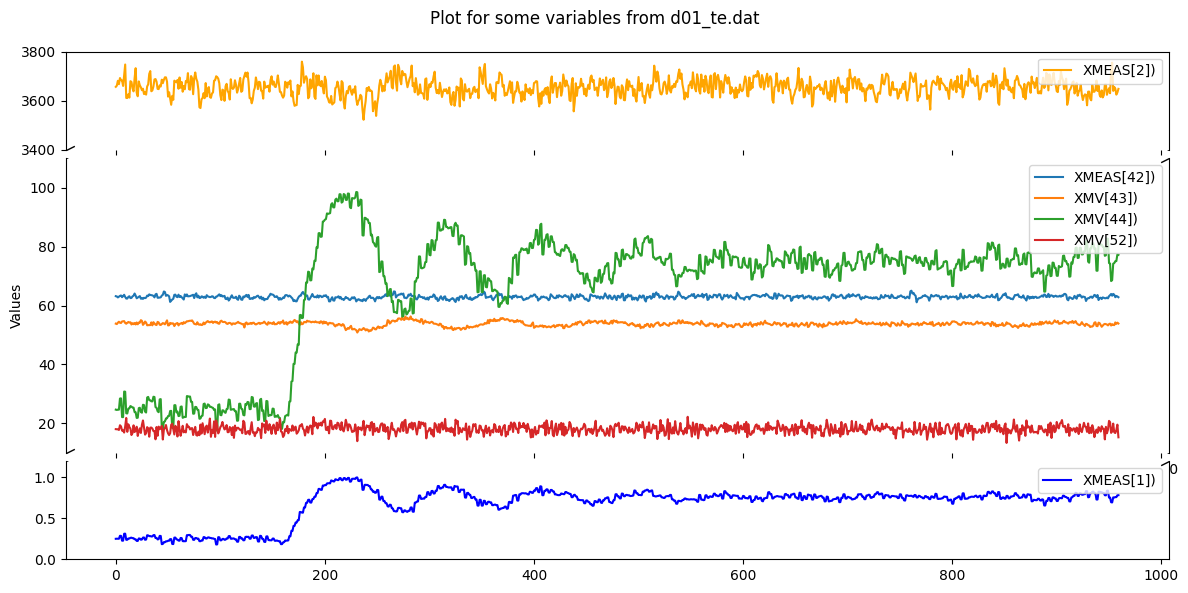

In [2]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 3, 1]})

ax1.plot(data[:, 1], label=col_names[1], color='orange')
ax1.set_ylim(3400, 3800)

for idx in [41, 42, 43, 51]:
    ax2.plot(data[:, idx], label=col_names[idx])

ax3.plot(data[:,0], label=col_names[0], color='blue')

ax2.set_ylim(10, 110)
ax3.set_ylim(0, 1.2)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)
ax2.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=True)

d = 0.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle='none', color='k', mec='k', mew=1)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 1], [1, 1], transform=ax3.transAxes, **kwargs)

ax2.set_xlabel("Time Step")
ax2.set_ylabel("Values")
fig.suptitle(f"Plot for some variables from {file_name}")
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.show()

C. Using a Model from Scikit learn - Used for Classifcation of Fault Class
(Short Description: The test data consists of faults only after 8 hours of data from its start. So the data points contained in these initial 8 hrs are assigned a healthy status and the data points after them as the respective fault number. All the test data files are then concatenated. )

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

def load_te_file_with_split(filepath, fault_label, healthy_rows=160):
    df = pd.read_csv(filepath, sep=r'\s+', header=None)
    df_healthy = df.iloc[:healthy_rows, :].copy()
    df_healthy['label'] = 0

    df_fault = df.iloc[healthy_rows:, :].copy()
    df_fault['label'] = fault_label

    return pd.concat([df_healthy, df_fault], ignore_index=True)

df_all = {}
for fault_num in range (0, 22):
    file_name = f'd{fault_num:02d}_te.dat'
    df_all[fault_num] = load_te_file_with_split(file_name, fault_label=fault_num)

df_final = pd.concat(df_all.values(), ignore_index=True)

X = df_final.iloc[:, :-1].values
y = df_final['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.99      0.77       864
           1       1.00      0.99      1.00       160
           2       1.00      0.97      0.99       160
           3       0.88      0.38      0.53       160
           4       0.95      0.99      0.97       160
           5       0.98      0.68      0.80       160
           6       1.00      1.00      1.00       160
           7       1.00      0.99      1.00       160
           8       1.00      0.99      0.99       160
           9       0.95      0.37      0.53       160
          10       0.95      0.90      0.92       160
          11       0.95      0.78      0.86       160
          12       0.99      0.99      0.99       160
          13       1.00      0.95      0.97       160
          14       0.99      0.95      0.97       160
          15       0.98      0.33      0.50       160
          16       0.95      0.90      0.92       160
          17       0.94    